#Libraries and Data Find Future list

In [1]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle
import xgboost as xgb
from datetime import datetime

from dataProcessing import DataProcessing
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
findFeature = False
features = ['Range', 'RSI', 'RSI_Ret', 'Avg_Range','TARGET']
symbol = "TATAMOTORS.NS"
stock_name = "TATAMOTORS"
df = pd.read_csv("../stock_historical_data/{}.csv".format(symbol))
df.set_index("Date", inplace=True)


In [3]:
#strat_mgr = StrategyManager(symbol, "", "",concatenated_df)
data = DataProcessing("TATAMOTORS",df)
print(data)

In [4]:
df_f = data.df.copy()

In [5]:
# Specify Target
df_f.loc[df_f["Range"].shift(-1) > df_f["Avg_Range"], "TARGET"] = 1
df_f.loc[df_f["Range"].shift(-1) <= df_f["Avg_Range"], "TARGET"] = 0

In [6]:
# Check for NaNs
nan_location = np.where(np.isnan(df_f))
nan_location
# Fill NA
df_f["TARGET"].fillna(0, inplace=True)
df_f.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-05,0.0,0.0,0.0,593.0,0.0,0.0,0.013762,123297.453428,81.102302,1.0,...,287.190476,4.150620,0.018151,0.0,0.013762,1.0,0.0,0.013762,1.0,0.0
2023-07-05,0.0,0.0,0.0,593.0,0.0,0.0,0.013762,123089.530235,81.102302,1.0,...,310.714286,4.158596,0.017915,0.0,0.013762,1.0,0.0,0.013762,1.0,0.0
2023-07-05,0.0,0.0,0.0,593.0,0.0,0.0,0.013762,122881.957672,81.102302,1.0,...,334.238095,4.157242,0.018193,0.0,0.013762,1.0,0.0,0.013762,1.0,0.0
2023-07-05,0.0,0.0,0.0,593.0,0.0,0.0,0.013762,122674.735146,81.102302,1.0,...,357.761905,4.989899,0.017971,0.0,0.013762,1.0,0.0,0.013762,1.0,0.0
2023-07-05,0.0,0.0,0.0,593.0,0.0,0.0,0.013762,122467.862068,81.102302,1.0,...,381.285714,4.989899,0.017750,0.0,0.013762,1.0,0.0,0.013762,1.0,0.0


In [7]:
# Remove unwanted columns
df_tts = df_f.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets", "Open", "High", "Low"], inplace=True)
# Find columns with infinite values
columns_with_inf = df_tts.columns[np.isinf(df_tts).any()]

#Drop columns with infinite values
df_tts.drop(columns_with_inf, axis=1, inplace=True)
has_inf = np.isinf(df_tts.values).any()

if has_inf:
    print("DataFrame contains NaN values",columns_with_inf)
else:
    print("DataFrame does not contain NaN values")

DataFrame does not contain NaN values


In [8]:

# Feature Selection
df_tts = df_tts.copy()
if findFeature == False:
    df_tts = df_tts[features]
df_tts

,Range,RSI,RSI_Ret,Avg_Range,TARGET
Date,,,,,
2005-02-16,0.042945,47.715626,0.811499,0.032276,1.0
2005-02-17,0.188465,45.791272,0.959670,0.038046,1.0
2005-02-18,0.073304,40.393484,0.882122,0.037757,0.0
2005-02-21,0.026261,39.589380,0.980093,0.037256,0.0
2005-02-22,0.017643,44.291938,1.118783,0.037049,0.0
...,...,...,...,...,...
2023-07-05,0.013762,81.102302,1.000000,0.018151,0.0
2023-07-05,0.013762,81.102302,1.000000,0.017915,0.0
2023-07-05,0.013762,81.102302,1.000000,0.018193,0.0


In [9]:
# Perform Train Test Split
# Split into Learning (X) and Target (y) Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)

# Perform Random Search for Best Hyper params
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Shape of X_train:  (3655, 4)
Shape of y_train:  (3655,)


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

Recommended Params >> ne: 80, lr: 0.3 md: 2 gm: 12


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [10]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [11]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.set_params(eval_metric=eval_metric_list)  # Example metric: 'error'

classifier_1.fit(
    X_train,
    y_train,
    #eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=12, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [12]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 0 0 0 0]


In [13]:
X_train

,Range,RSI,RSI_Ret,Avg_Range
Date,,,,
2008-04-09,0.020531,43.354554,1.016713,0.042122
2011-06-23,0.027746,27.423322,1.132935,0.028416
2017-12-12,0.023525,44.225752,0.952991,0.026391
2017-12-06,0.022785,35.465719,0.928562,0.027078
2010-04-09,0.044039,61.485340,1.126601,0.035471
...,...,...,...,...
2023-01-19,0.019245,47.037061,0.903670,0.022259
2006-12-29,0.026572,59.467051,0.988674,0.040250
2017-08-30,0.014042,32.720776,1.068973,0.024788


In [14]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [15]:
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

In [16]:
# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("")
print("Just for reference. Right now, we are only focussed on getting some initial features.")
print("If the results look too good to be true, they probably are.")

Average Accuracy K-Fold:  0.62
Std Deviation K-Fold:  0.04
Precision Score 0:  0.65
Precision Score 1:  0.667

Just for reference. Right now, we are only focussed on getting some initial features.
If the results look too good to be true, they probably are.


In [17]:
classifier_1.fit(
    X,
    y,
    #eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=12, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

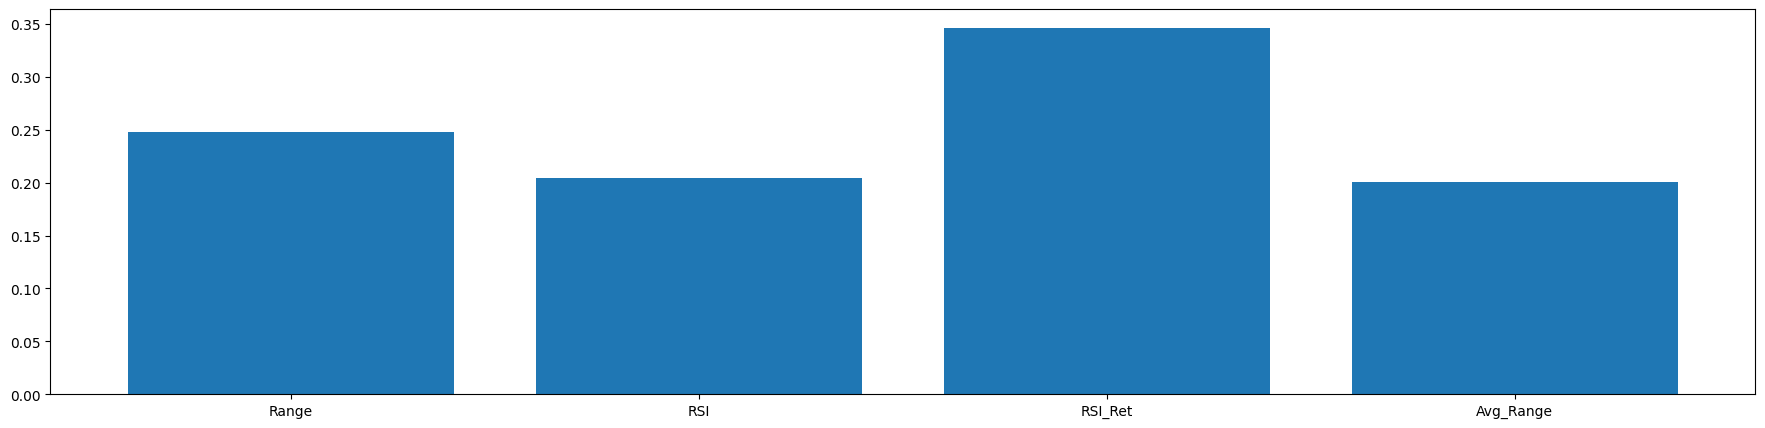

In [18]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [19]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

In [20]:
recommended_feature_labels

['RSI_Ret']

In [21]:
# Save the trained model to a file
if findFeature == False:
    with open('../TrainedModel/xg/{}_model_2.pkl'.format(symbol), 'wb') as f:
        pickle.dump(classifier_1, f)

In [22]:
# Save the trained model to a file
if findFeature == True:
    print(recommended_feature_labels)
    with open('../TrainedModel/xg/{}_features.txt'.format(symbol), 'wb') as f:
        pickle.dump(recommended_feature_labels, f)